# Import

In [2]:
import os, joblib
import numpy as np
import pandas as pd
from math import ceil, floor
from itertools import combinations

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rcParams['font.family'] = 'Helvetica'

import seaborn as sns

from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Concatenate

from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

from scipy.stats import ttest_ind as ttest

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Load Data

## RNA

In [4]:
rna = pd.read_csv('../../data/processed/cellLineEncoderPretrainData.csv', index_col=0)

## Drugs

In [5]:
drugs = pd.read_csv('../../data/processed/drug_fingerprints.csv', index_col=0)

## MOAs

In [6]:
cdr = pd.read_csv('../../data/processed/drugCellLinePairsData.csv')
moas = cdr.loc[:, ['name', 'moa']].drop_duplicates(keep='first')
moas.rename(columns={'name': 'drug'}, inplace=True)
moas = moas[moas.drug.isin(list(drugs.index))].set_index('drug')
moas = moas[moas.moa.isin(list(moas.moa.value_counts()[moas.moa.value_counts() >= 10].index))]

getMOA = lambda x: moas.loc[x, :][0]
drugList = list(moas.index)

## Cancer types

In [7]:
info = pd.read_csv('../../data/processed/cellLineInfo.csv').loc[:, ['DepMap_ID', 'primary_disease']]
info = info.rename(columns={'primary_disease': 'cancer_type', 'DepMap_ID': 'cell_line'})
info = info[info.cell_line.isin(list(rna.index))].set_index('cell_line', drop=True)
getCT = lambda x: info.loc[x, :][0]

# Raw RNA tsne

In [8]:
rawTSNE = pd.DataFrame(TSNE(n_components=2, init='random').fit_transform(rna), index=rna.index)
rawTSNE.insert(0, 'cancer_type', [getCT(cellLine) for cellLine in list(rna.index)])

# Define funcs

In [9]:
def loadEncoder(path, which='rna'):
    try:
        snn = load_model(path)
        encoder = snn.get_layer('model')
        encoder._name = f'{which}Encoder'
        return encoder
    except AttributeError:
        return None

# RF Embeddings

## RNA

In [10]:
rnaPath = '../../models/cellEncoders/'
rnaModel = 'CellLineFewShot_Layers2_Hidden64_DO0-1_AFrelu_LR0-001_DR0-99_DS1000'
rnaPath = os.path.join(rnaPath, rnaModel)
rnaEmbed = loadEncoder(rnaPath)

In [11]:
rnaEmbeddings = pd.DataFrame(rnaEmbed(rna.to_numpy()).numpy(), index=rna.index)
rnaEmbeddings.insert(0, 'cancer_type', [getCT(cellLine) for cellLine in list(rnaEmbeddings.index)])
rnaEmbeddings.head()

,cancer_type,0,1,2,3,4,5,6,7,8,...,54,55,56,57,58,59,60,61,62,63
ACH-001289,Rhabdoid,0.0,0.0,0.0,0.0,0.000000,0.0,0.518141,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.169183,0.0,0.457829,0.0
ACH-001339,Skin Cancer,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.147524,0.0,0.0,0.0,1.013961,0.0,0.000000,0.0
ACH-001538,Bile Duct Cancer,0.0,0.0,0.0,0.0,0.622538,0.0,0.849156,0.0,0.0,...,0.0,1.008909,0.234708,0.0,0.0,0.0,0.358598,0.0,0.000000,0.0
ACH-000708,Colon/Colorectal Cancer,0.0,0.0,0.0,0.0,0.000000,0.0,0.893929,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
ACH-000327,Lung Cancer,0.0,0.0,0.0,0.0,0.000000,0.0,0.042873,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.098728,0.0,0.122655,0.0


In [12]:
cdrTSNErna = pd.DataFrame(TSNE(n_components=2, init='random').fit_transform(rna.iloc[:, 1:]), index=rnaEmbeddings.index)
cdrTSNErna.insert(0, 'cancer_type', rnaEmbeddings.cancer_type)


## Drugs

In [13]:
drugPath = '../../models/drugEncoders/'
drugModel = 'DrugFewShot_Layers1_Hidden64_DO0-1_AFrelu_LR0-001_DR0-99_DS1000'
drugPath = os.path.join(drugPath, drugModel)
drugEmbed = loadEncoder(drugPath, which='drug')

In [14]:
drugSubset = drugs.loc[drugList, :]
drugEmbeddings = pd.DataFrame(drugEmbed(drugSubset.to_numpy()).numpy(), index=drugSubset.index)
drugEmbeddings.insert(0, 'moa', [getMOA(drug) for drug in list(drugEmbeddings.index)])
drugEmbeddings.head()

,moa,0,1,2,3,4,5,6,7,8,...,54,55,56,57,58,59,60,61,62,63
belinostat,HDAC inhibitor,0.0,0.0,4.733480,2.116385,0.000000,1.359826,0.000000,2.276699,2.795123,...,1.109962,2.636456,0.0,0.000000,0.935001,0.0,0.0,1.395575,2.279768,2.110241
romidepsin,HDAC inhibitor,0.0,0.0,5.026449,2.037010,0.000000,1.293311,0.000000,2.727001,3.474960,...,0.949178,3.398749,0.0,0.009806,0.717597,0.0,0.0,1.668294,1.469026,1.555456
puromycin,protein synthesis inhibitor,0.0,0.0,0.000000,1.656208,3.103661,0.000000,2.341359,0.000000,4.596645,...,0.000000,0.000000,0.0,0.000000,4.124204,0.0,0.0,2.730622,0.000000,0.000000
cycloheximide,protein synthesis inhibitor,0.0,0.0,0.881959,1.227137,2.496884,0.000000,1.917890,0.000000,5.178120,...,0.000000,0.000000,0.0,0.000000,3.429098,0.0,0.0,2.328746,0.000000,0.000000
RGFP966,HDAC inhibitor,0.0,0.0,5.520843,1.719670,0.000000,0.019688,0.000000,2.469327,3.348505,...,0.000000,2.458517,0.0,0.000000,1.874853,0.0,0.0,2.042814,0.453671,2.721272


In [15]:
cdrTSNEdrug = pd.DataFrame(TSNE(n_components=2, init='random').fit_transform(drugEmbeddings.iloc[:, 1:]), index=drugEmbeddings.index)
cdrTSNEdrug.insert(0, 'moa', drugEmbeddings.moa)

## DeepDSC

### Load model

In [16]:
dscPath = '../../models/DeepDSC/'
dscModel = 'DeepDSC_fold2'
dscPath = os.path.join(dscPath, dscModel)
dsc = load_model(dscPath)

rnaInput = Input(shape=463, name='rna')
ae = dsc.get_layer('encoder')
AE = Model(inputs=rnaInput, outputs=ae(rnaInput))

In [17]:
dscEmbeddings = pd.DataFrame(AE(rna.to_numpy()).numpy(), index=rna.index)
dscEmbeddings.insert(0, 'cancer_type', [getCT(cellLine) for cellLine in list(dscEmbeddings.index)])
dscEmbeddings.head()

,cancer_type,0,1,2,3,4,5,6,7,8,...,22,23,24,25,26,27,28,29,30,31
ACH-001289,Rhabdoid,21.560524,-4.600863,-5.601335,14.959680,84.007286,39.670219,-25.901674,-1.622540,-14.493036,...,31.515160,-7.084526,99.437477,-9.614636,-2.213378,32.522522,48.142254,31.854723,68.153740,-4.651627
ACH-001339,Skin Cancer,22.892403,-4.922985,-6.977116,11.705415,89.637764,38.319714,-25.736265,-1.172204,-15.489100,...,36.401066,-7.141747,105.290337,-10.784549,-2.682678,35.794403,52.787197,35.410877,74.957336,-5.482809
ACH-001538,Bile Duct Cancer,26.289768,-3.466034,-8.066165,15.369724,81.841827,41.446384,-26.197708,-2.637902,-13.696660,...,35.381786,-7.055945,98.223480,-10.750059,-2.936413,38.123817,44.005596,34.194675,64.135338,-4.944628
ACH-000708,Colon/Colorectal Cancer,23.243246,-3.256840,-7.324371,12.940812,81.453018,40.333603,-25.441477,-1.869221,-14.233493,...,34.467007,-6.987257,97.587662,-10.636830,-2.616166,36.374592,46.771610,34.100342,63.628464,-4.908471
ACH-000327,Lung Cancer,24.209332,-5.978451,-6.918748,16.259144,83.902298,38.851749,-25.293184,-1.423608,-14.456236,...,35.260906,-6.973253,100.115334,-10.110357,-2.224427,35.100475,46.667641,32.247635,66.023582,-4.049247


In [18]:
dscTSNE = pd.DataFrame(TSNE(n_components=2, init='random').fit_transform(dscEmbeddings.iloc[:, 1:]), index=dscEmbeddings.index)
dscTSNE.insert(0, 'cancer_type', dscEmbeddings.cancer_type)


In [35]:
drugTSNE = pd.DataFrame(TSNE(n_components=2, init='random').fit_transform(drugSubset), index=drugSubset.index)
drugTSNE.insert(0, 'moa', [getMOA(drug) for drug in list(drugSubset.index)])


# Embedding dicts

In [36]:
embeddings = {'DeepDSC cell line AE': dscEmbeddings,
              'Cell line SNN': rnaEmbeddings,
              'Morgan fingerprints': drugSubset,
              'Drug SNN': drugEmbeddings}

tsnes = {'DeepDSC cell line AE': dscTSNE,
         'Cell line SNN': cdrTSNErna,
         'Morgan fingerprints': drugTSNE,
         'Drug SNN': cdrTSNEdrug}

# Similarities

In [37]:
def sim_by_type(rep, tsne, sim, cnt=5):
    intra_avgs = []
    inter_avgs = []
    common_cancers = tsne.iloc[:, 0].value_counts()[tsne.iloc[:, 0].value_counts() > cnt].index.tolist()
    for ct in common_cancers:
        intra = rep[(tsne.iloc[:, 0] == ct)].index.tolist()
        inter = rep[(tsne.iloc[:, 0] != ct)].index.tolist()

        n_intra = 0
        intra_sum = 0
        for i, j in combinations(intra, 2):
            n_intra += 1
            intra_sum += sim.loc[i, j]

        intra_avgs.append(intra_sum / n_intra)

        n_inter = 0
        inter_sum = 0
        for i, j in combinations(inter, 2):
            n_inter += 1
            inter_sum += sim.loc[i, j]

        inter_avgs.append(inter_sum / n_inter)

    return pd.DataFrame({'intra_avg_sim': intra_avgs, 'inter_avg_sim': inter_avgs}, index=common_cancers)

## Raw rna sim

In [38]:
rawSim = cosine_similarity(rna)
rawSim = pd.DataFrame(rawSim, index=rna.index, columns=rna.index)

In [39]:
rawAvgSim = sim_by_type(rna, rawTSNE, rawSim, 5)
rawAvgSim['diff'] = rawAvgSim.intra_avg_sim / rawAvgSim.inter_avg_sim

In [40]:
rawAvgSim.head()

,intra_avg_sim,inter_avg_sim,diff
Lung Cancer,0.952152,0.934062,1.019367
Leukemia,0.949659,0.938720,1.011653
Lymphoma,0.945193,0.939264,1.006312
Brain Cancer,0.959541,0.934911,1.026344
Skin Cancer,0.962394,0.934894,1.029415


## Model embedding sims

In [41]:
sims = {}
for e, rep in embeddings.items():
    sim = cosine_similarity(rep.iloc[:, 1:])
    sims[e] = pd.DataFrame(sim, index=rep.index, columns=rep.index)

In [42]:
avgSims = {}
for e, rep in embeddings.items():
    if ('drug' in e.lower()) | ('fingerprint' in e.lower()):
        cnt = 10
    else:
        cnt = 5
    df = sim_by_type(rep, tsnes[e], sims[e], cnt)
    df['diff'] = df.intra_avg_sim / df.inter_avg_sim
    avgSims[e] = df

In [43]:
pairs = [('DeepDSC cell line AE', 'Cell line SNN'),
         ('Morgan fingerprints', 'Drug SNN')]

In [44]:
for (p1, p2) in pairs:
    s1 = avgSims[p1]; s2 = avgSims[p2]
    d1 = s1['diff'].mean(); d2 = s2['diff'].mean()
    pval = ttest(s1['diff'], s2['diff']).pvalue
    sim1 = s1.intra_avg_sim.mean(); sim2 = s2.intra_avg_sim.mean()
    
    print(f'{p1} avg intra-group sim: {sim1}')
    print(f'{p1} avg inter-group sep: {d1}\n')
    print(f'{p2} avg intra-group sim: {sim2}')
    print(f'{p2} avg inter-group sep: {d2}\n')
    
    print(f"Percent improvement in intra-group similarity of {p2} over {p1}: {round(((sim2-sim1)/sim1)*100,2)}%")
    print(f"Percent improvement in intra-group vs inter-group difference of {p2} over {p1}: {round(((d2-d1)/d1)*100,2)}%",\
          f"(p-value: {pval})\n")
    

DeepDSC cell line AE avg intra-group sim: 0.9993848488876705
DeepDSC cell line AE avg inter-group sep: 1.0002830102212283

Cell line SNN avg intra-group sim: 0.9109291947506358
Cell line SNN avg inter-group sep: 1.7708200443409357

Percent improvement in intra-group similarity of Cell line SNN over DeepDSC cell line AE: -8.85%
Percent improvement in intra-group vs inter-group difference of Cell line SNN over DeepDSC cell line AE: 77.03% (p-value: 2.789486707130894e-29)

Morgan fingerprints avg intra-group sim: 0.405333338451225
Morgan fingerprints avg inter-group sep: 1.1927522629742386

Drug SNN avg intra-group sim: 0.7681113138895206
Drug SNN avg inter-group sep: 1.9182157812558551

Percent improvement in intra-group similarity of Drug SNN over Morgan fingerprints: 89.5%
Percent improvement in intra-group vs inter-group difference of Drug SNN over Morgan fingerprints: 60.82% (p-value: 3.168137178852871e-06)



## Raw

In [45]:
rawD = rawAvgSim['diff']
rawS = rawAvgSim.intra_avg_sim
print(f"Raw intra-group sim: {rawS.mean()}")
print(f"Raw inter-group sep: {rawD.mean()}")

Raw intra-group sim: 0.9583854691521831
Raw inter-group sep: 1.0244591088473227


In [46]:
def getPChng(sim):
    s = avgSims[sim]
    sD = s['diff']
    sS = s.intra_avg_sim
    
    intraChng = 100 * ((sS.mean() - rawS.mean()) / rawS.mean())
    intraP = ttest(sS, rawS).pvalue
    interChng = 100 * ((sD.mean() - rawD.mean()) / rawD.mean())
    interP = ttest(sD, rawD).pvalue
    
    print(f"%Change (Intra-Sim): {round(intraChng, 2)} (p={intraP})")
    print(f"%Change (Intra-Sep): {round(interChng, 2)} (p={interP})")

## DSC vs. Raw

In [47]:
getPChng('DeepDSC cell line AE')

%Change (Intra-Sim): 4.28 (p=3.437229713554988e-34)
%Change (Intra-Sep): -2.36 (p=1.0790273543998824e-20)


## SiamCDR vs. Raw

In [48]:
getPChng('Cell line SNN')

%Change (Intra-Sim): -4.95 (p=0.00869020259301873)
%Change (Intra-Sep): 72.85 (p=1.3382676058711529e-28)


# Save t-SNE's

In [22]:
# joblib.dump(tsnes, './tsneDFs.joblib')

['./tsneDFs.joblib']

# Create tsne plots

In [19]:
tsnes = joblib.load('./tsneDFs.joblib')

In [20]:
def getPalette(opts):
    shapeOpts = ['X', 's', '^', 'p']
#     shapeOpts = ['+', 'x', '3', '$\dagger$']
    while len(shapeOpts) < len(opts):
        shapeOpts.extend(shapeOpts)
    colorOpts = sns.color_palette('husl', n_colors=len(opts))
    optDict = {}
    for i, opt in enumerate(opts):
        try:
            optDict[opt] = (shapeOpts[i], colorOpts[i])
        except ZeroDivisionError:
            optDict[opt] = (shapeOpts[0], colorOpts[0])
        
    return optDict

In [21]:
cl = 'Cell line SNN'
cTypesPlotSubset = list(tsnes[cl].cancer_type.value_counts()[tsnes[cl].cancer_type.value_counts() >= 15].index)

In [22]:
abbrev = {'HDAC inhibitor': 'HDAC-INH',
         'protein synthesis inhibitor': 'PS-INH',
         'PI3K inhibitor': 'PI3K-INH',
         'topoisomerase inhibitor': 'Top-INH',
         'histamine receptor antagonist': 'H2RA',
         'mTOR inhibitor': 'mTOR-INH',
         'tubulin polymerization inhibitor': 'Tub-INH',
         'HSP inhibitor': 'HSP-INH',
         'EGFR inhibitor': 'EGFR-INH',
         'adrenergic receptor antagonist': 'AR-ANT',
         'adrenergic receptor agonist': 'AR-Ag',
         'cyclooxygenase inhibitor': 'COX-INH',
         'glucocorticoid receptor agonist': 'GR-Ag',
         'MEK inhibitor': 'MEK-INH',
         'CDK inhibitor': 'CDK-INH',
         'Aurora kinase inhibitor': 'AK-INH'}

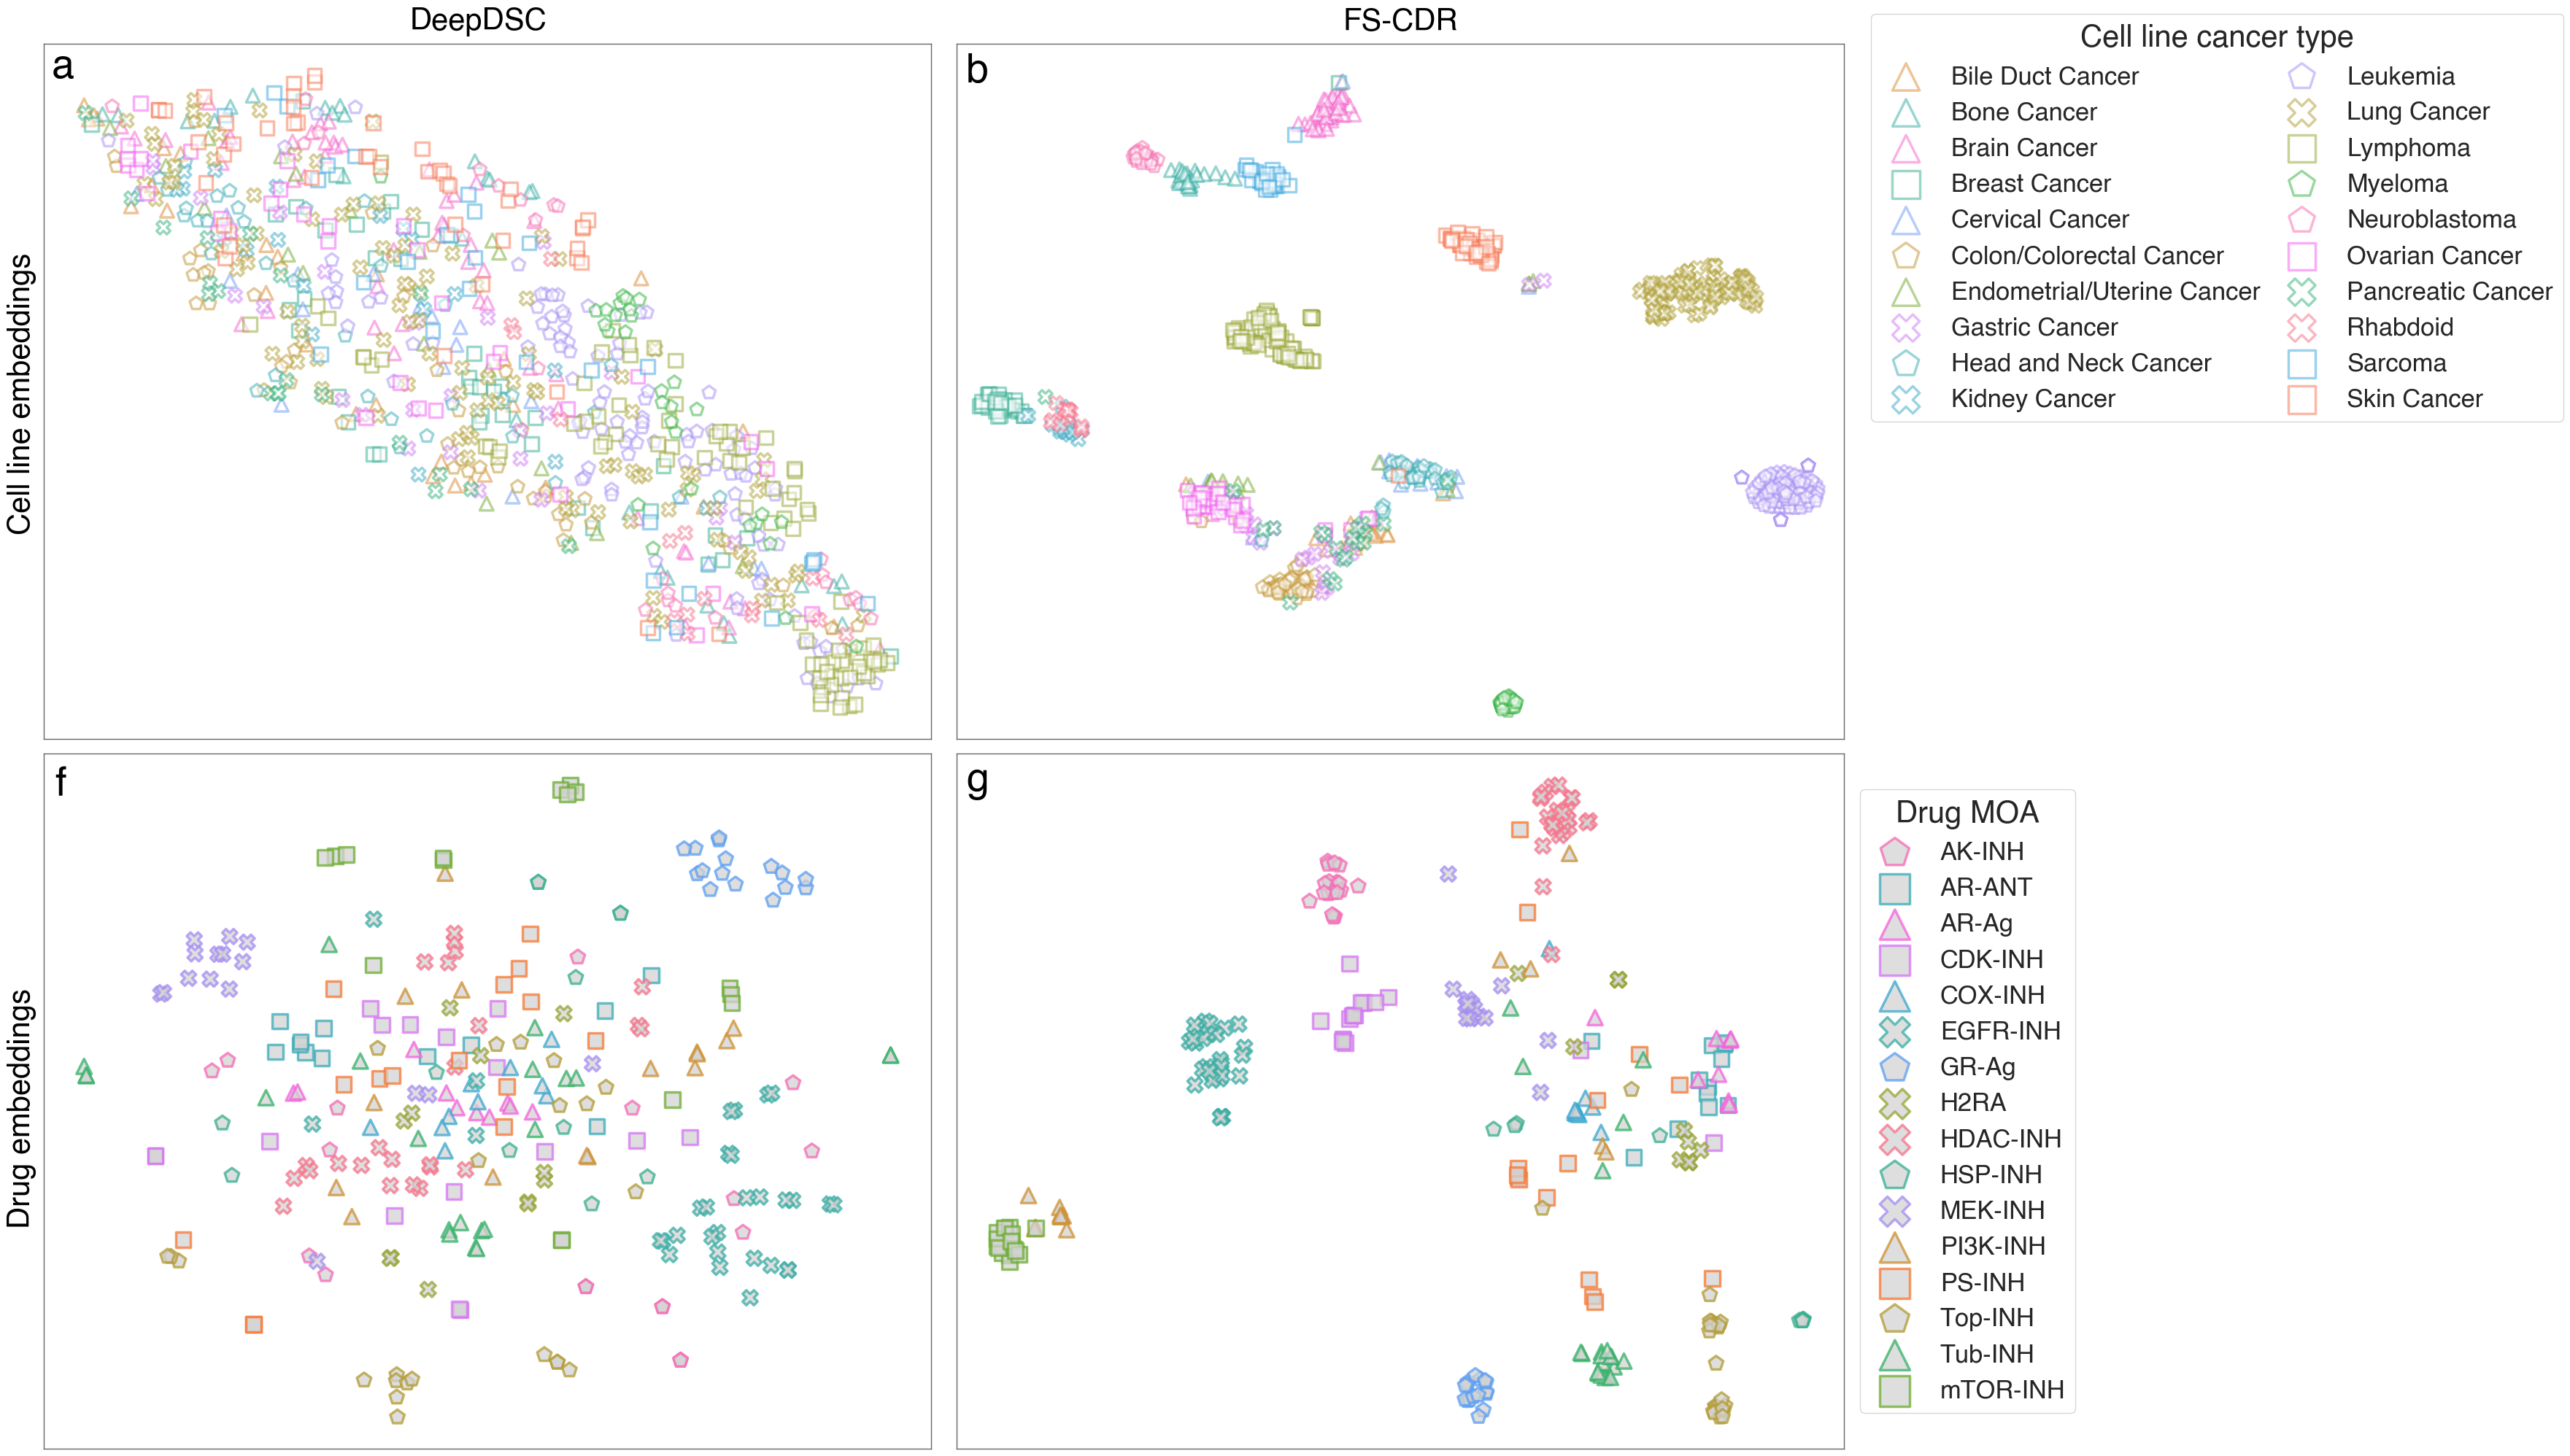

In [23]:
# define stylistic settings
sns.set_theme()
sns.set_context("paper")
sns.set(font_scale = 2.25)
rc = {'axes.facecolor': 'white',
      'axes.grid': True,
      'grid.color': '0.8',
      'font.family': 'sans-serif',
      'font.sans-serif': 'Helvetica',
      'axes.unicode_minus': False}
plt.rcParams.update(rc)

# create blank figure
fig, ax = plt.subplots(2, 2, sharex='none', sharey='none', 
                       figsize=(35,20), constrained_layout=True)

# iterate through each tsne embedding
for i, (name, vals) in enumerate(tsnes.items()):
    vals = vals.copy().rename(columns={0:'ft1', 1:'ft2'}) # rename tsne cols
    
    # Define ax specific conditions
    if i < 2: 
        r = 0; c = i; col = 'cancer_type'; alpha=0.5; size=180; facecolor='white'
        vals = vals[vals[col].isin(cTypesPlotSubset)]       
    else: 
        r = 1; c = i - 2; col = 'moa'; alpha=0.75; size=220; facecolor='lightgrey'
        vals[col] = vals[col].apply(abbrev.get)
        
    # Define colors
    colors = []       
    opts = getPalette(list(vals[col].unique()))
    for g in vals[col]:
        try: 
            h = opts[g][1]
        except KeyError:
            h = 'lightgray'
        colors.append(h)
    vals['color'] = colors
        
    # Get subplot
    subplt = ax[r][c]
    
    # plot each group with marker / color combo
    for ct, subvals in vals.groupby(by=col):
        subplt.scatter(y=subvals.ft2, x=subvals.ft1, 
                       edgecolor=subvals.color, facecolor=facecolor, marker=opts[ct][0], 
                       s=size, linewidth=2.5, alpha=alpha, label=ct)
        
#     if i == 3:
#         keyDrugs = ['brefeldin-a', 'CUDC-907', 'YM-201636', 'BNC105']
#         subsub = vals[vals.index.isin(keyDrugs)]
#         subplt.scatter(y=subsub.ft2, x=subsub.ft1, 
#                        edgecolor=subvals.color, facecolor='red', marker=opts[ct][0], 
#                        s=size, linewidth=2.5, alpha=alpha, label=ct)
    
    # Remove single cell line outlier for FS-RF
    if i == 1:
        subplt.set_ylim(-50, 50)
        subplt.set_xlim(-37, 40)
    
    # define which gets legend
    if i in [1,3]:
        if '_' in col:
            legTitle = 'Cell line ' + " ".join(col.split('_'))
            a1 = 1.825; a2 = 0.75; nc = 2
        else:
            legTitle = 'Drug MOA'
            a1 = 1.275; a2 = 0.5; nc = 1
        subplt.legend(title=legTitle, title_fontsize=30,
                      loc=7, bbox_to_anchor=(a1, a2), 
                      markerscale=2, ncol=nc, columnspacing=0.65)
    # Format subplots
    subplt.set_xticks([])
    subplt.set_yticks([])
    for border in ['top', 'bottom', 'left', 'right']:
        subplt.spines[border].set_visible(True)
        subplt.spines[border].set_color("0.4")
        subplt.spines[border].set_linewidth(1)
        
ax[0][0].text(-60.4, 24.3, 'a', color='black', weight='bold', fontsize=40)
ax[0][0].text(-2, 28.5, 'DeepDSC', color='black', fontsize=30, horizontalalignment='center')
ax[0][0].text(-66.5, -3, 'Cell line embeddings', color='black', fontsize=30, 
              rotation='vertical', verticalalignment='center')

ax[0][1].text(-36.2, 44.5, 'b', color='black', weight='bold', fontsize=40)
ax[0][1].text(1.5, 52, 'FS-CDR', color='black', fontsize=30, horizontalalignment='center')

ax[1][0].text(-21.75, 22, 'f', color='black', weight='bold', fontsize=40)
ax[1][0].text(-24.1, 0, 'Drug embeddings', color='black', fontsize=30, 
              rotation='vertical', verticalalignment='center')

ax[1][1].text(-23.4, 10, 'g', color='black', weight='bold', fontsize=40)

# plt.savefig("./figure4.pdf", dpi=1200, bbox_inches="tight")
plt.show()

# Magnify cell line clusters

In [27]:
# Load data
col='cancer_type' 
vals = tsnes['Cell line SNN'].copy().rename(columns={0:'ft1', 1:'ft2'})
vals = vals[vals[col].isin(cTypesPlotSubset)]

# Define colors
colors = []       
opts = getPalette(list(vals[col].unique()))
for g in vals[col]:
    try: 
        h = opts[g][1]
    except KeyError:
        h = 'lightgray'
    colors.append(h)
vals['color'] = colors

# Basic params
alpha=0.5
size=180   

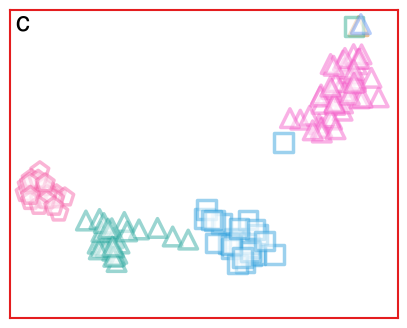

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))

for ct, subvals in vals.groupby(by=col):
    ax.scatter(y=subvals.ft2, x=subvals.ft1, 
                edgecolor=subvals.color, facecolor='white', marker=opts[ct][0], 
                s=size, linewidth=2.5, alpha=alpha, label=ct)
    
ax.set_xlim(-22.5, -1.5)
ax.set_xticks([])
ax.set_ylim(25.5, 45.5)
ax.set_yticks([])

for border in ['top', 'bottom', 'left', 'right']:
    ax.spines[border].set_visible(True)
    ax.spines[border].set_color("#e41d1f")
    ax.spines[border].set_linewidth(1.5)
    
ax.text(-22.2, 44.2, 'c', color='black', weight='bold', fontsize=20)
# ax.text(-32.35, -7.3, 'Cluster 2', fontsize=20, color="#377eb8")

# plt.savefig("./figure4_cluster1.pdf", dpi=1200, bbox_inches="tight")
plt.show()

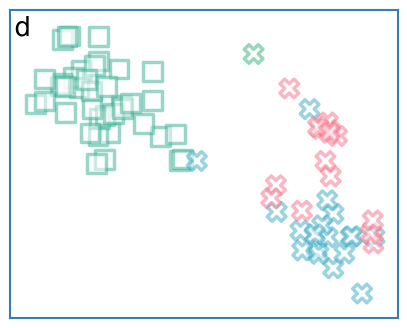

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))

for ct, subvals in vals.groupby(by=col):
    ax.scatter(y=subvals.ft2, x=subvals.ft1, 
                edgecolor=subvals.color, facecolor='white', marker=opts[ct][0], 
                s=size, linewidth=2.5, alpha=alpha, label=ct)
    
ax.set_xlim(-35.7,-25.5)
ax.set_xticks([])
ax.set_ylim(-7.5, 0.3)
ax.set_yticks([])

for border in ['top', 'bottom', 'left', 'right']:
    ax.spines[border].set_visible(True)
    ax.spines[border].set_color("#377eb8")
    ax.spines[border].set_linewidth(1.5)
    
ax.text(-35.6, -0.35, 'd', color='black', weight='bold', fontsize=20)
# ax.text(-32.35, -7.3, 'Cluster 2', fontsize=20, color="#377eb8")

# plt.savefig("./figure4_cluster2.pdf", dpi=1200, bbox_inches="tight")
plt.show()

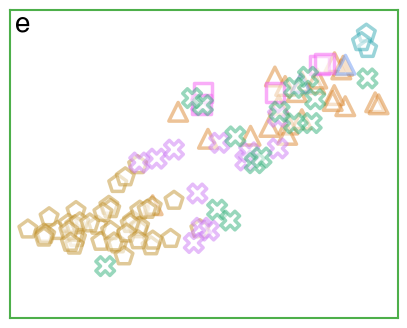

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))

vals = vals[~((vals.ft1 < -8) & (vals.ft2 > -22))]

for ct, subvals in vals.groupby(by=col):
    ax.scatter(y=subvals.ft2, x=subvals.ft1, 
                edgecolor=subvals.color, facecolor='white', marker=opts[ct][0], 
                s=size, linewidth=2.5, alpha=alpha, label=ct)
    
ax.set_xlim(-11, 1)
ax.set_xticks([])
ax.set_ylim(-33.5, -15)
ax.set_yticks([])

for border in ['top', 'bottom', 'left', 'right']:
    ax.spines[border].set_visible(True)
    ax.spines[border].set_color("#4daf4a")
    ax.spines[border].set_linewidth(1.5)
    
ax.text(-10.85, -16.3, 'e', color='black', weight='bold', fontsize=20)
# ax.text(-6.85, -33, 'Cluster 3', fontsize=20, color="#4daf4a")

# plt.savefig("./figure4_cluster3.pdf", dpi=1200, bbox_inches="tight")
plt.show()

# Magnify drug clusters

In [31]:
# Load data
col='moa' 
vals = tsnes['Drug SNN'].copy().rename(columns={0:'ft1', 1:'ft2'})
vals[col] = vals[col].apply(abbrev.get)

# Define colors
colors = []       
opts = getPalette(list(vals[col].unique()))
for g in vals[col]:
    try: 
        h = opts[g][1]
    except KeyError:
        h = 'lightgray'
    colors.append(h)
vals['color'] = colors

# Basic params
alpha=0.75
size=220
fc='lightgrey'  

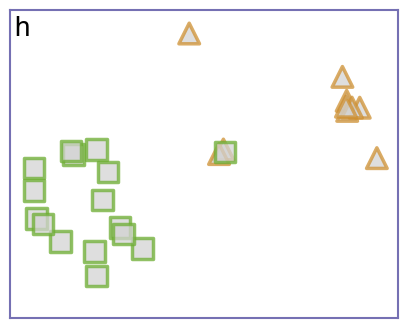

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))

for ct, subvals in vals.groupby(by=col):
    ax.scatter(y=subvals.ft2, x=subvals.ft1, 
                edgecolor=subvals.color, facecolor=fc, marker=opts[ct][0], 
                s=size, linewidth=2.5, alpha=alpha, label=ct)
    
ax.set_xlim(-22.3, -18.9)
ax.set_xticks([])
ax.set_ylim(-6, -3.2)
ax.set_yticks([])

for border in ['top', 'bottom', 'left', 'right']:
    ax.spines[border].set_visible(True)
    ax.spines[border].set_color("#7570b3")
    ax.spines[border].set_linewidth(1.5)
    
ax.text(-22.26, -3.44, 'h', color='black', weight='bold', fontsize=20)
# ax.text(-32.35, -7.3, 'Cluster 2', fontsize=20, color="#377eb8")

# plt.savefig("./figure4_cluster4.pdf", dpi=1200, bbox_inches="tight")
plt.show()

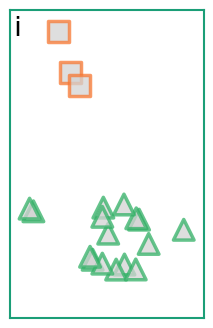

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,4))

for ct, subvals in vals.groupby(by=col):
    ax.scatter(y=subvals.ft2, x=subvals.ft1, 
                edgecolor=subvals.color, facecolor=fc, marker=opts[ct][0], 
                s=size, linewidth=2.5, alpha=alpha, label=ct)
    
ax.set_xlim(2.85, 5.18)
ax.set_ylim(-10.1, -5.9)
ax.set_xticks([])
ax.set_yticks([])

for border in ['top', 'bottom', 'left', 'right']:
    ax.spines[border].set_visible(True)
    ax.spines[border].set_color("#1b9e77")
    ax.spines[border].set_linewidth(1.5)
    
ax.text(2.9, -6.25, 'i', color='black', weight='bold', fontsize=20)
# ax.text(-32.35, -7.3, 'Cluster 2', fontsize=20, color="#377eb8")

# plt.savefig("./figure4_cluster5.pdf", dpi=1200, bbox_inches="tight")
plt.show()

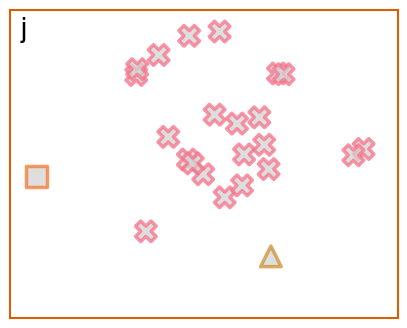

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

vals = vals[~((vals.ft1 < -8) & (vals.ft2 > -22))]

for ct, subvals in vals.groupby(by=col):
    ax.scatter(y=subvals.ft2, x=subvals.ft1, 
                edgecolor=subvals.color, facecolor=fc, marker=opts[ct][0], 
                s=size, linewidth=2.5, alpha=alpha, label=ct)
    
ax.set_xlim(0.2, 3.75)
ax.set_ylim(7.3, 10.4)
ax.set_xticks([])
ax.set_yticks([])

for border in ['top', 'bottom', 'left', 'right']:
    ax.spines[border].set_visible(True)
    ax.spines[border].set_color("#d95f02")
    ax.spines[border].set_linewidth(1.5)
    
ax.text(0.3, 10.13, 'j', color='black', weight='bold', fontsize=20)
# ax.text(-6.85, -33, 'Cluster 3', fontsize=20, color="#4daf4a")

# plt.savefig("./figure4_cluster6.pdf", dpi=1200, bbox_inches="tight")
plt.show()

In [35]:
t = tsnes['Drug SNN']

In [36]:
t.moa.unique()

array(['HDAC inhibitor', 'protein synthesis inhibitor', 'PI3K inhibitor',
       'topoisomerase inhibitor', 'histamine receptor antagonist',
       'mTOR inhibitor', 'tubulin polymerization inhibitor',
       'HSP inhibitor', 'EGFR inhibitor',
       'adrenergic receptor antagonist', 'cyclooxygenase inhibitor',
       'glucocorticoid receptor agonist', 'MEK inhibitor',
       'CDK inhibitor', 'adrenergic receptor agonist',
       'Aurora kinase inhibitor'], dtype=object)

## Examine classification of NAs

In [37]:
tsneDrugs = list(t.index)
moas = ['PI3K inhibitor', 'mTOR inhibitor', 'EGFR inhibitor', 
        'CDK inhibitor', 'glucocorticoid receptor agonist',
        'Aurora kinase inhibitor', 'tubulin polymerization inhibitor',
        'HDAC inhibitor']
cdrSegMOA = cdr[cdr.name.isin(tsneDrugs) & (cdr.moa.isin(moas))].loc[:, ['name', 'moa', 'target', 'indication']].drop_duplicates(keep='first')
cdrSegMOA

,name,moa,target,indication
347,belinostat,HDAC inhibitor,"HDAC1, HDAC10, HDAC11, HDAC2, HDAC3, HDAC4, HD...",peripheral T-cell lymphoma (PTCL)
387,romidepsin,HDAC inhibitor,"HDAC1, HDAC2, HDAC3, HDAC4, HDAC5, HDAC6, HDAC...",cutaneous T-cell lymphoma (CTCL)
1101,RGFP966,HDAC inhibitor,HDAC3,NaN
1662,PI-828,PI3K inhibitor,NaN,NaN
3017,PP242,mTOR inhibitor,"MTOR, PASK",NaN
...,...,...,...,...
58123,poziotinib,EGFR inhibitor,"EGFR, ERBB2, ERBB4",NaN
58511,tucatinib,EGFR inhibitor,ERBB2,NaN
58512,vindesine,tubulin polymerization inhibitor,"TUBB, TUBB1","breast cancer, non-small cell lung cancer (NSC..."
60060,PI3K-IN-2,PI3K inhibitor,NaN,NaN


In [38]:
cdrSegMOA[cdrSegMOA.target.isna()]

,name,moa,target,indication
1662,PI-828,PI3K inhibitor,NaN,NaN
11392,indibulin,tubulin polymerization inhibitor,NaN,NaN
30476,plinabulin,tubulin polymerization inhibitor,NaN,NaN
34680,YM-201636,PI3K inhibitor,NaN,NaN
36011,combretastatin-A-4,tubulin polymerization inhibitor,NaN,NaN
38922,pilaralisib,PI3K inhibitor,NaN,NaN
40668,TG-100713,PI3K inhibitor,NaN,NaN
41561,M-344,HDAC inhibitor,NaN,NaN
45831,R306465,HDAC inhibitor,NaN,NaN
47585,taltobulin,tubulin polymerization inhibitor,NaN,NaN


In [39]:
# compare PI3K center
t[(t.moa == 'PI3K inhibitor') & (~t.index.isin(['PI-828', 'YM-201636', 'pilaralisib', 'PI3K-IN-2', 'TG-100713', 'CUDC-907']))].mean()

0   -19.547571
1    -4.192241
dtype: float32

In [40]:
t[(t.moa == 'PI3K inhibitor') & (t.index.isin(['PI-828', 'YM-201636', 'pilaralisib', 'PI3K-IN-2', 'TG-100713']))]

,moa,0,1
PI-828,PI3K inhibitor,4.013199,-1.770302
YM-201636,PI3K inhibitor,-20.727577,-3.413701
pilaralisib,PI3K inhibitor,0.916255,4.096707
TG-100713,PI3K inhibitor,4.161310,-1.967589
PI3K-IN-2,PI3K inhibitor,-0.378229,4.394473


In [41]:
# compare PI3K center
t[(t.moa == 'tubulin polymerization inhibitor') & (~t.index.isin(['indibulin', 'plinabulin', 'taltobulin', 'BNC105', 'nocodazole', 'combretastatin-A-4']))].mean()

0    4.001436
1   -8.989261
dtype: float32

In [42]:
t[(t.moa == 'tubulin polymerization inhibitor') & (t.index.isin(['indibulin', 'plinabulin', 'taltobulin', 'BNC105']))]

,moa,0,1
indibulin,tubulin polymerization inhibitor,0.055814,2.801407
plinabulin,tubulin polymerization inhibitor,4.024914,-2.589196
taltobulin,tubulin polymerization inhibitor,4.919209,-0.992286
BNC105,tubulin polymerization inhibitor,4.939353,-8.897046


## Examine protein synthesis w/ tubulin polymerization inhibitors

In [43]:
subset = t[((t[0] < 5) & (t[0] > 0)) & (t[1] < -5)]

In [44]:
drugSubset = list(subset.index)
subset.sort_values(by='moa').head(10)

,moa,0,1
brefeldin-a,protein synthesis inhibitor,3.436090,-6.196681
clindamycin-phosphate,protein synthesis inhibitor,3.688029,-6.929410
methacycline,protein synthesis inhibitor,3.578050,-6.752577
parbendazole,tubulin polymerization inhibitor,4.226462,-9.370715
BNC105,tubulin polymerization inhibitor,4.939353,-8.897046
CYT-997,tubulin polymerization inhibitor,3.960062,-8.720332
flubendazole,tubulin polymerization inhibitor,3.812800,-9.265142
dolastatin-10,tubulin polymerization inhibitor,4.031003,-8.949802
vincristine,tubulin polymerization inhibitor,3.972488,-8.595027
oxibendazole,tubulin polymerization inhibitor,4.362323,-9.438025


In [45]:
cdrSub = cdr[cdr.name.isin(drugSubset)].loc[:, ['name', 'moa', 'target', 'indication', 'phase']].drop_duplicates(keep='first')
cdrSub = cdrSub.sort_values(by='moa')
cdrSub

,name,moa,target,indication,phase
53476,brefeldin-a,protein synthesis inhibitor,"ARF1, CYTH2",NaN,Preclinical
38812,clindamycin-phosphate,protein synthesis inhibitor,NaN,bacterial vaginosis,Launched
29011,methacycline,protein synthesis inhibitor,NaN,bronchitis,Launched
3343,parbendazole,tubulin polymerization inhibitor,TUBB,NaN,Preclinical
54653,BNC105,tubulin polymerization inhibitor,NaN,NaN,Phase 2
53320,CYT-997,tubulin polymerization inhibitor,TUBB,NaN,Phase 2
38628,flubendazole,tubulin polymerization inhibitor,TUBB,gastrointestinal parasites,Launched
37680,dolastatin-10,tubulin polymerization inhibitor,TUBB,NaN,Phase 2
36536,vincristine,tubulin polymerization inhibitor,"TUBA4A, TUBB",acute lymphoblastic leukemia (ALL),Launched
33726,oxibendazole,tubulin polymerization inhibitor,"TUBB, TUBB4B",strongyles,Launched


In [46]:
cdrSub[(cdrSub.name == 'vinorelbine')].target

5529    TUBA1A, TUBA1B, TUBA1C, TUBA3C, TUBA3D, TUBA3E...
Name: target, dtype: object

In [47]:
cdrSub.iloc[-4, 2]

'TUBA1A, TUBA1B, TUBA1C, TUBA3C, TUBA3D, TUBA3E, TUBA4A, TUBB, TUBB1, TUBB2A, TUBB2B, TUBB3, TUBB4A, TUBB4B, TUBB6, TUBB8'

In [48]:
cdr[cdr.name == 'brefeldin-a'].sort_values(by='effectiveCont', ascending=False).head(15)

,DepMap_ID,cancer_type,name,moa,target,indication,phase,r2,ic50,auc,lower_limit,effectiveCont,effective
53498,ACH-000620,Liver Cancer,brefeldin-a,protein synthesis inhibitor,"ARF1, CYTH2",NaN,Preclinical,0.829014,0.107756,0.533150,0.000030,12.128464,1
53627,ACH-000553,Lung Cancer,brefeldin-a,protein synthesis inhibitor,"ARF1, CYTH2",NaN,Preclinical,0.753344,0.388010,0.665182,0.000069,10.291199,1
53488,ACH-000856,Breast Cancer,brefeldin-a,protein synthesis inhibitor,"ARF1, CYTH2",NaN,Preclinical,0.822509,0.116874,0.541594,0.000206,10.134817,1
53557,ACH-000086,Lung Cancer,brefeldin-a,protein synthesis inhibitor,"ARF1, CYTH2",NaN,Preclinical,0.717198,0.092082,0.517085,0.000375,9.745299,1
53561,ACH-000566,Bladder Cancer,brefeldin-a,protein synthesis inhibitor,"ARF1, CYTH2",NaN,Preclinical,0.753681,0.116564,0.541390,0.000367,9.561590,1
53558,ACH-000762,Head and Neck Cancer,brefeldin-a,protein synthesis inhibitor,"ARF1, CYTH2",NaN,Preclinical,0.716949,0.119303,0.544119,0.001163,8.389957,1
53526,ACH-000292,Lung Cancer,brefeldin-a,protein synthesis inhibitor,"ARF1, CYTH2",NaN,Preclinical,0.855217,0.067332,0.485809,0.002957,7.963516,1
53544,ACH-001318,Liver Cancer,brefeldin-a,protein synthesis inhibitor,"ARF1, CYTH2",NaN,Preclinical,0.804342,0.106741,0.533806,0.003639,7.348255,1
53605,ACH-000962,Ovarian Cancer,brefeldin-a,protein synthesis inhibitor,"ARF1, CYTH2",NaN,Preclinical,0.747717,0.155008,0.571788,0.002895,7.259921,0
53592,ACH-000966,Ovarian Cancer,brefeldin-a,protein synthesis inhibitor,"ARF1, CYTH2",NaN,Preclinical,0.799249,0.257205,0.623502,0.002066,7.194829,0
